In [1]:
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import pandas as pd
import talib
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error
from keras import backend as K
import keras
from keras.models import *
from keras.layers import *
from keras import layers
import time
import timeit
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from statistics import mean 
import requests
from datetime import date, timedelta

C:\Users\Mihan Perera\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
'''
Time2Vec class adds time embeddings to the input. This is called later when time distributed layer 
is defined for the time series transformer 
'''
class Time2Vec(keras.layers.Layer):   
    
    def __init__(self, kernel_size=1): #passes kernel size as a parameter to the constructor
        #calls the constructor of the super class and names it 'Time2VecLayer' and makes it trainable
        super(Time2Vec, self).__init__(trainable=True, name='Time2VecLayer')
        self.k = kernel_size
    
    def build(self, input_shape):
        
        #defines the weights and bias of the trend function and makes them trainable
        self.wb = self.add_weight(name='wb',shape=(input_shape[1],),initializer='uniform',trainable=True)
        self.bb = self.add_weight(name='bb',shape=(input_shape[1],),initializer='uniform',trainable=True)
        
        #defines the weights and bias of the periodic function and makes them trainable
        self.wa = self.add_weight(name='wa',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
        self.ba = self.add_weight(name='ba',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
        super(Time2Vec, self).build(input_shape)
    
    #'call' is an inbuilt function of Time2Vec class which gets called automatically everytime the class instance is created
    def call(self, inputs, **kwargs): 
        
        #computes the bias term by elementwise multiplication with self.wb and then adds self.bb 
        bias = self.wb * inputs + self.bb
        
        dp = K.dot(inputs, self.wa) + self.ba
        #adds non-linearity to the computation
        weights = K.sin(dp) 
        
        #concatenates the bias and weights along the -1 axis
        ret = K.concatenate([K.expand_dims(bias, -1), weights], -1) 
        #flattens the tensor into a 2D shape
        ret = K.reshape(ret, (-1, inputs.shape[1]*(self.k+1))) 
        return ret
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]*(self.k + 1))
        
        

In [3]:
class ETL:
    """
    This class performs Extract, Transform, and Load (ETL) operations on historical stock data.
    It extracts data for a given stock ticker from Yahoo Finance, splits the data into train, validation and test sets,
    reshapes the data into the required format, and converts the problem into a supervised learning problem.
    """
    def __init__(self, ticker=[], test_size=0.2, period='max', n_input=5, timestep=5) -> None:
        """
        Constructor for the ETL class.

        Parameters:
        - ticker: List of stock tickers.
        - test_size: Fraction of data to be used as the test set.
        - period: Time period for fetching historical data ('max' by default).
        - n_input: Number of input time steps for the supervised learning problem.
        - timestep: Number of time steps used to reshape the data.

        Initializes attributes, fetches historical data, and performs ETL operations.
        """
        self.ticker = ticker
        self.period = period
        self.test_size = test_size
        self.n_input = n_input
        self.df = self.extract_historic_data()
        self.timestep = timestep
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)
        

    def extract_historic_data(self) -> pd.Series:
        """
        Fetches historical stock data using Yahoo Finance API.
        Creates a pandas dataframe with the closing prices of each stock of the portfolio
        """
        # Fetch historical data using yfinance
        start_date = '2010-01-13'
        end_date = '2023-12-26'
        delta = timedelta(days=1)
        
        # Create an empty DataFrame
        df = pd.DataFrame()

        # Fetch and append closing prices for each stock
        for symbol in self.ticker:
            stock_data = yf.download(symbol, start=start_date, end=end_date)
            df[symbol] = stock_data['Close']
            
        #updates the database by removing the rows with missing values
        df.dropna(inplace=True)
        return df

    def split_data(self) -> tuple:
        """
        Splits historical data into train and test sets.
        Returns training and test sets as numpy arrays
        """
        #calls self.extract_historic_data() to retrieve historical stock prices of each stock
        data = self.extract_historic_data()
        
        if len(data) != 0:
            
            #calculates the number of data points for training set
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]
            
            #the rest of the data points are used as test data
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            
            #Raises an exception if the dataset is empty
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs, 
        which is, [no of samples, timestep, no of assets]
        """
        no_assets = len(self.ticker)
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        return result.reshape((samples, self.timestep, no_assets))

    def transform(self, train, test) -> np.array:
        """
        Applies data transformation to test and train sets.
        Returns the transformed test and train sets
        """
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self) -> tuple[np.array, np.array]:
        """
        Performs the complete ETL process.
        Returns a tuple which contains train and test sets after ETL.
        """
        train, test = self.split_data()
        return self.transform(train, test)
    
    def features(self, period, stock_val):
        """
        Extracts additional features from historical stock data.
        Returns a pandas DataFrame with additional features
        """
        df_hist = self.extract_historic_data()
        stock = self.ticker[stock_val]
       
        df = pd.DataFrame()
        df[stock] = df_hist[stock]
        
        #uses talib library to calculate Relative Strength Index
        df['RSI'] = talib.RSI(df_hist[stock], timeperiod=period)
        df['MoM'] = df_hist[stock].diff(1)
        
        #uses talib library to calculate Exponential Moving Average
        df['EMA'] = talib.EMA(df_hist[stock], timeperiod=period)
        
        #Calculating Rolling averages, 5day, 10day and 20day
        df['5_Day_MA'] = df_hist[stock].rolling(window=5).mean()
        df['10_Day_MA'] = df_hist[stock].rolling(window=10).mean()
        df['20_Day_MA'] = df_hist[stock].rolling(window=20).mean()
        
        return df
    
    def to_supervised(self, input_data, n_out=5) -> tuple: 
        """
        Converts the time series prediction problem to a supervised learning problem.
        Returns the input and output sequences for supervised learning
        """
    
        stocks = self.ticker
        num_stocks = len(stocks)
        data_x = []
        data_y = []
        
        for i in range(len(self.ticker)):
            
            #calculates the number of rows
            num_rows = input_data.shape[0]*input_data.shape[1]

            #generates a value for each stock to distinguish them during training 
            stock_ticker_val = np.full((num_rows, 1), i+1)
            
            #calls the self.features function and computes all the features required for supervised learning
            stock_with_ft = np.array(self.features(period =5, stock_val = i))
            print(stock_with_ft.shape)
            
            samples = int(stock_with_ft.shape[0] / self.timestep)
            features = np.array(np.array_split(stock_with_ft, samples))           
            feature_array = []
            
            if (np.array(features).shape[0]/2) > input_data.shape[0]:
                feature_array = np.array(features[-input_data.shape[0]:])
            else:
                feature_array = np.array(features[:input_data.shape[0]])
                
        
            #create separate arrays for each feature 
            new_array = input_data[:,:, i].reshape((input_data.shape[0]*input_data.shape[1],1))
            rsi = feature_array[:,:,1].reshape((feature_array.shape[0]*feature_array.shape[1],1))
            mom = feature_array[:,:,2].reshape((feature_array.shape[0]*feature_array.shape[1],1))
            ema = feature_array[:,:,3].reshape((feature_array.shape[0]*feature_array.shape[1],1))
            five_day = feature_array[:,:,4].reshape((feature_array.shape[0]*feature_array.shape[1],1))
            ten_day = feature_array[:,:,5].reshape((feature_array.shape[0]*feature_array.shape[1],1))
            twenty_day = feature_array[:,:,6].reshape((feature_array.shape[0]*feature_array.shape[1],1))
            
            #stacks all the input features together and creates a new numpy array
            reshaped_array = np.hstack((new_array, rsi, five_day, ten_day, twenty_day, stock_ticker_val)) 
            
            
            X, y = [], []
            in_start = 20 
            
            # step over the entire history one time step at a time
            for _ in range(len(reshaped_array)):
                
                # define the end of the input sequence
                in_end = in_start + self.n_input
                out_end = in_end + n_out
                
                # ensure we have enough data for this instance
                if out_end <= len(reshaped_array):
                    x_input = reshaped_array[in_start:in_end, :]
                    x_input = x_input.reshape((len(x_input), 6))
                    X.append(x_input)
                    y.append(reshaped_array[in_end:out_end, 0])
                    
                    # move along one time step
                    in_start += 1
            
            data_x.append(X)
            data_y.append(y)
            
        data_x = np.array(data_x)
        data_y = np.array(data_y)
        print(data_x.shape)
        return data_x, data_y

In [4]:
class PredictAndForecast():
    """
    This class takes a trained model, train, and test datasets and returns predictions
    of length len(test) with the same shape.
    """
    def __init__(self, model, train, test, n_input=5) -> None:
        
        """
        Constructor for the PredictAndForecast class.
        
        Parameters:
        model: Trained TensorFlow/Keras model.
        train: Numpy array representing the training data.
        test: Numpy array representing the testing data.
        n_input: Number of input time steps for forecasting.

        Initializes attributes and computes predictions using the trained model.
        """
        self.model = model
        self.train = train
        self.test = test
        self.n_input = n_input
        self.predictions = self.get_predictions()


    def forecast(self, history) -> np.array:
        
        """
        Given last week's actual data, forecasts next week's prices.
        """
    
        data = np.array(history)               
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        
        # retrieve last observations for input data
        input_x = data[-self.n_input:, :]
      
        # reshape into [1, n_input, 1]
        input_x = input_x.reshape((1, len(input_x), input_x.shape[1]))
       
        # forecast the next week
        yhat = self.model.predict(input_x, verbose=0)
        yhat = yhat[0]
        return yhat
        
    def get_predictions(self) -> np.array:
        """
        Compiles model predictions week by week over the entire test set.
        Returns an array containing predictions for each week.
        """
        # history is a list of weekly data
        history = [x for x in self.train]
        
        # walk-forward validation over each week
        predictions = []
        for i in range(len(self.test)):
            yhat_sequence = self.forecast(history)
            
            # store the predictions
            predictions.append(yhat_sequence)
            
            # get real observation and add to history for predicting the next week
            history.append(self.test[i, :])
      
        return np.array(predictions)

In [5]:
class Evaluate:
  """
  This class is used for evaluating model predictions against actual values.
  """

  def __init__(self, actual, predictions) -> None:
    """
        Constructor for the Evaluate class.

        Parameters:
        actual: Numpy array representing actual values.
        predictions: Model predictions.

        Initializes attributes and calculates evaluation metrics.
    """
    self.actual = actual[:,:,0] #we only need the closing price from the actual data 
    self.predictions = predictions
    self.var_ratio = self.compare_var()
    self.mape = self.evaluate_model_with_mape()

  def compare_var(self):
    """
        Compares the variance of predictions to the variance of actual values.
    """
    return abs( 1 - (np.var(self.predictions) / np.var(self.actual)))

  def evaluate_model_with_mape(self):
    """
        Evaluates the model using Mean Absolute Percentage Error (MAPE).
    """
    return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

In [6]:
def random_portfolio():
    '''
    Creates a random portfolio of 10 assets using the FTSE top 20 each time it is called
    '''
    my_list = ['NG.L', 'CPG.L', 'RIO.L', 'GSK.L','HSBA.L', 'BP.L', 'LLOY.L', 'BATS.L', 'ULVR.L', 'SHEL.L', 'LIN', 'DGE.L', 'REL.L', 'LSEG.L', 'AON', 'RKT.L', 'BA.L', 'FERG.L', 'RR.L', 'AAL.L']
    no_assets = 10  
    assets = random.sample(my_list, no_assets)
    return assets

In [8]:
data = ETL(my_list)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [40]:

def build_lstm(etl: ETL, epochs=35, batch_size=32) -> tf.keras.Model:
  """
  Builds, compiles, and fits Sen et al. LSTM model.
  """
  n_timesteps, n_features, n_outputs = 5, 6, 5
  
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(256, input_shape = (n_timesteps, n_features), activation = "relu", return_sequences = True),
                                      tf.keras.layers.Dropout(0.3),
                                      tf.keras.layers.LSTM(256, activation = "relu"),
                                      tf.keras.layers.Dropout(0.3),
                                      tf.keras.layers.Dense(256, activation = "relu"),
                                      tf.keras.layers.Dense(n_outputs, activation = "relu")
                                      ])
  print('compiling baseline model...')
  model.compile(optimizer='adam', loss='huber', metrics=['mae', 'mape'])
  print('fitting model...')

  hist = 0 
  for stocks in range(data.X_train.shape[0]):
      callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
      start = time.time()
      hist = model.fit(data.X_train[stocks], data.y_train[stocks], batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
      print(time.time() - start)
  return model, hist


In [41]:
#training the LSTM model
baseline = build_lstm(data)

compiling baseline model...
fitting model...
Epoch 1/25
85/85 [==============================] - 10s 69ms/step - loss: 912.1725 - mae: 912.6722 - mape: 21.3223
Epoch 2/25
85/85 [==============================] - 6s 67ms/step - loss: 444.9268 - mae: 445.4263 - mape: 10.5276
Epoch 3/25
85/85 [==============================] - 6s 68ms/step - loss: 375.7171 - mae: 376.2167 - mape: 8.8054
Epoch 4/25
85/85 [==============================] - 6s 71ms/step - loss: 305.1885 - mae: 305.6882 - mape: 7.2868
Epoch 5/25
85/85 [==============================] - 7s 80ms/step - loss: 286.3835 - mae: 286.8831 - mape: 6.8137
Epoch 6/25
85/85 [==============================] - 6s 68ms/step - loss: 260.1181 - mae: 260.6176 - mape: 6.2435
Epoch 7/25
85/85 [==============================] - 5s 62ms/step - loss: 256.8293 - mae: 257.3290 - mape: 6.0833
Epoch 8/25
85/85 [==============================] - 6s 66ms/step - loss: 241.6321 - mae: 242.1317 - mape: 5.7765
Epoch 9/25
85/85 [==============================

In [42]:
baseline_model = baseline[0]
history = baseline[1]

In [18]:
def gated_residual_network(inputs, hidden_dim):
    x = layers.LayerNormalization()(inputs)
    
    g1 = layers.Dense(hidden_dim, activation="linear")(x)
    g2 = layers.Dense(hidden_dim, activation="elu")(x)
    
    g = layers.multiply([g1, g2])
    g = layers.Dense(x.shape[-1])(g)
    grn_output = layers.add([x, g])
    
    return grn_output

In [9]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout, epsilon=1e-6, attention_axes=None, kernel_size=1):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=epsilon)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(inputs, inputs)
  x = layers.Dropout(dropout)(x)
    
  #residual connections as mentioned in model architecture
  res = inputs + x 
    
 # Feed Forward Part of the encoder block
  x = layers.LayerNormalization(epsilon=epsilon)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
  
  #residual connections as mentioned in model architecture
  res1 = res + x
  return res1

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout, mlp_dropout, attention_axes=None, epsilon=1e-6, kernel_size=1):
  """
  Creates final model by building many transformer blocks.
  """

  n_timesteps, n_features, n_outputs = 5, 6, 5 
  time2vec = Time2Vec(kernel_size=1)
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  
  #creating the time distributed layer using Time2Vec class
  time_embedding = keras.layers.TimeDistributed(time2vec)(inputs)
  x = K.concatenate([inputs, time_embedding], -1)

  #building each transformer block
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  #applying global average pooling to the output of the transformer
  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

  #applying a dense layer to the output of global average pooling
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)
    
  #final dense layer which calculates the output of the neural network
  outputs = layers.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)

In [10]:
transformer = build_transfromer(head_size=128, num_heads=8, ff_dim=2, num_trans_blocks=1, mlp_units=[256], mlp_dropout=0.1, dropout=0.1, attention_axes=1)

In [11]:
transformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 6)]       0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 5, 12)       24          ['input_1[0][0]']                
 ted)                                                                                             
                                                                                                  
 tf.concat (TFOpLambda)         (None, 5, 18)        0           ['input_1[0][0]',                
                                                                  'time_distributed[0][0]']       
                                                                                              

In [12]:
import time
import tensorflow as tf
from functools import partial

def fit_transformer(transformer, data):
    """
    Fits a transformer model on the provided data.

    Parameters:
    - transformer: The transformer model to be fitted.
    - data: Object containing training data (X_train, y_train).

    Returns:
    - list: List of training histories for each stock.
    """
    
    # Compile the transformer model with Mean Squared Error loss, Adam optimizer, and metrics (MAE, MAPE)
    transformer.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["mae", 'mape']
    )

    def lr_scheduler(epoch, lr, warmup_epochs=15, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
        """
        Learning rate scheduler function with warm-up and decay.

        Parameters:
        - epoch: Current epoch.
        - lr: Current learning rate.
        - warmup_epochs: Number of warm-up epochs.
        - decay_epochs: Number of decay epochs.
        - initial_lr: Initial learning rate.
        - base_lr: Base learning rate.
        - min_lr: Minimum learning rate.

        Returns:
        - float: Updated learning rate.
        """
        if epoch <= warmup_epochs:
            pct = epoch / warmup_epochs
            return ((base_lr - initial_lr) * pct) + initial_lr

        if warmup_epochs < epoch < warmup_epochs + decay_epochs:
            pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
            return ((base_lr - min_lr) * pct) + min_lr

        return min_lr
    
    # Define callbacks, including early stopping and the learning rate scheduler
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(partial(lr_scheduler, warmup_epochs=15, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5), verbose=0)
    ]

    total_time = 0
    all_histories = []

    # Iterate through each stock and train the transformer model
    for stock in range(data.X_train.shape[0]):
        start = time.time()
        history = transformer.fit(
            data.X_train[stock],
            data.y_train[stock],
            batch_size=32,
            epochs=35,
            verbose=1,
            callbacks=callbacks
        )
        total_time += time.time() - start
        all_histories.append(history)

    print(f"Total training time: {total_time} seconds")

    return all_histories


In [19]:
hist = fit_transformer(transformer, data)

Epoch 1/35
85/85 [==============================] - 5s 18ms/step - loss: 136109.0000 - mae: 272.7477 - mape: 6.4220 - lr: 1.0000e-06
Epoch 2/35
85/85 [==============================] - 1s 17ms/step - loss: 134229.2031 - mae: 269.2352 - mape: 6.3138 - lr: 6.7600e-05
Epoch 3/35
85/85 [==============================] - 1s 17ms/step - loss: 138880.8281 - mae: 275.3953 - mape: 6.4883 - lr: 1.3420e-04
Epoch 4/35
85/85 [==============================] - 1s 17ms/step - loss: 137136.4844 - mae: 273.3956 - mape: 6.4477 - lr: 2.0080e-04
Epoch 5/35
85/85 [==============================] - 1s 18ms/step - loss: 148474.2656 - mae: 282.5521 - mape: 6.6520 - lr: 2.6740e-04
Epoch 6/35
85/85 [==============================] - 1s 18ms/step - loss: 140831.3125 - mae: 277.2174 - mape: 6.4935 - lr: 3.3400e-04
Epoch 7/35
85/85 [==============================] - 2s 19ms/step - loss: 139808.3438 - mae: 274.3634 - mape: 6.4742 - lr: 4.0060e-04
Epoch 8/35
85/85 [==============================] - 2s 18ms/step - lo

In [14]:
def convert_preds(dataa, timestep, NUM_FEATURES, ticker):
    """
    Converts predicted data to the required format for evaluation.

    Parameters:
    - dataa: Predicted data.
    - timestep: Number of time steps used to reshape the data.
    - NUM_FEATURES: Number of features in the data.
    - ticker: List of stock tickers.

    Returns:
    - np.array: Reshaped data in the format [# samples, timestep, # features].
    """
    data_new = []

    for i in range(len(ticker)):

        num_rows = dataa.shape[0]*dataa.shape[1]
        stock_ticker_val = np.full((num_rows, 1), i+1)
        
        stock_with_ft = np.array(data.features(period =10, stock_val = i))
        
        samples = int(stock_with_ft.shape[0] / timestep)
        features = np.array(np.array_split(stock_with_ft, samples))
       

        feature_array = []
        if (features.shape[0]/2) > dataa.shape[0]:
            feature_array = features[-dataa.shape[0]:]
            
        else:
            feature_array = features[:dataa.shape[0]]   
        
        new_array = dataa[:,:, i].reshape((dataa.shape[0]*dataa.shape[1],1))
        rsi = feature_array[:,:,1].reshape((feature_array.shape[0]*feature_array.shape[1],1))
        mom = feature_array[:,:,2].reshape((feature_array.shape[0]*feature_array.shape[1],1))
        ema = feature_array[:,:,3].reshape((feature_array.shape[0]*feature_array.shape[1],1))
        five_day = feature_array[:,:,4].reshape((feature_array.shape[0]*feature_array.shape[1],1))
        ten_day = feature_array[:,:,5].reshape((feature_array.shape[0]*feature_array.shape[1],1))
        twenty_day = feature_array[:,:,6].reshape((feature_array.shape[0]*feature_array.shape[1],1))
        reshaped_array = np.hstack((new_array, rsi, five_day, ten_day, twenty_day, stock_ticker_val)) #add the sentiment analysis here
        data_new.append(reshaped_array.reshape((dataa.shape[0], timestep, NUM_FEATURES)))
        
    return np.array(data_new)


In [20]:
start = time.time()
train = convert_preds(data.train, data.timestep, 6, data.ticker)
test = convert_preds(data.test, data.timestep, 6, data.ticker)
predict = []

#predicts future stock prices for each asset
for i in range(len(data.ticker)):
    predict.append(PredictAndForecast(transformer, train[i], test[i]))
    print(time.time() - start)
    


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [24]:
def feature_selection_RFE_RF(test):
    """
    Performs feature selection using Recursive Feature Elimination (RFE) with Random Forest (RF) as the base model.

    Parameters:
    - test: Numpy array containing time-series data.

    Prints:
    - Mean Squared Error for each iteration during cross-validation.
    - Selected features after RFE.

    Returns:
    - None
    """
    
    # Reshape the test data for analysis
    new_test = test[0].reshape((test[0].shape[0]*test[0].shape[1],test[0].shape[2]))
    
    # Create a DataFrame for easier data manipulation
    df1 = pd.DataFrame(new_test, columns=['close', 'rsi', 'mom', 'ema', '5day', '10day', '20day', 'ticker'])
    new_df1 = pd.DataFrame()
    new_df1 = df1.iloc[0:-5]
    
    # Prepare target variable
    target = df1['close'].iloc[5:]
    target.reset_index(drop=True, inplace=True)
    new_df1['target']=target
    
    # Define features and target variable
    X = new_df1[['close', 'rsi', 'mom', 'ema', '5day', '10day', '20day']]
    y = new_df1['target']

    # Standardize the features using StandardScaler
    scaler = StandardScaler()
    
    # Model for RFE
    model = RandomForestRegressor()

    # Time series split for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    #RFE
    rfe = RFE(model, n_features_to_select=5)
    
    # Perform cross-validation and RFE
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit and transform the scaler on the training data
        X_train_scaled = scaler.fit_transform(X_train)

        # Transform the test data using the same scaler
        X_test_scaled = scaler.transform(X_test)
        
        rfe.fit(X_train_scaled, y_train)

        # Transform features using RFE
        X_train_rfe = rfe.transform(X_train_scaled)
        X_test_rfe = rfe.transform(X_test_scaled)

        # Train a model (Random Forest in this case) using selected features
        model.fit(X_train_rfe, y_train)

        # Make predictions
        y_pred = model.predict(X_test_rfe)

        # Evaluate model performance
        mse = mean_squared_error(y_test, y_pred)
        print(f'Mean Squared Error: {mse}')

    # Selected features after RFE
    selected_features = X.columns[rfe.support_]
    print('Selected Features:', selected_features)

    

In [25]:
feature_selection_RFE_RF(test)

C:\Users\Mihan Perera\AppData\Local\Temp\ipykernel_20176\3415106846.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df1['target']=target


Mean Squared Error: 282.3656946280358
Mean Squared Error: 209.96054434527136
Mean Squared Error: 158.25810723310653
Mean Squared Error: 718.8059642573011
Mean Squared Error: 516.3202001481977
Selected Features: Index(['close', 'rsi', '5day', '10day', '20day'], dtype='object')


In [16]:
def saving_results(pred, test):
    """
    Save prediction and test results to CSV files and print evaluation metrics for each stock.

    Parameters:
    - pred: List containing prediction results for each stock.
    - test: Numpy array containing test data.

    Returns:
    - pd.DataFrame: DataFrames containing saved test and prediction results.
    """
    
    # Extract the close prices from the test data
    test = test[:,:,:,0]
    
    # Reshape prediction and test data for analysis
    sav_pred = pred[0].predictions.reshape((pred[0].predictions.shape[0]*pred[0].predictions.shape[1],1))
    sav_test = test[0].reshape((test[0].shape[0]*test[0].shape[1],1))
     
    # Concatenate prediction and test data for each stock
    for i in range(1, len(data.ticker)):
        new_pred = pred[i].predictions.reshape((pred[i].predictions.shape[0]*pred[i].predictions.shape[1],1))
        new_test = test[i].reshape((test[i].shape[0]*test[i].shape[1],1))
        sav_pred = np.hstack((sav_pred,new_pred))
        sav_test = np.hstack((sav_test,new_test))
        
    # Create DataFrames for saved test and prediction results
    test_results = pd.DataFrame(sav_test)
    pred_results = pd.DataFrame(sav_pred)
    
    # Rename columns with stock tickers
    for i in range(len(data.ticker)):
        test_results.rename(columns={i: data.ticker[i]}, inplace=True)
        pred_results.rename(columns={i: data.ticker[i]}, inplace=True)

    # Save test and prediction results to CSV files
    test_results.to_csv('test_tt_02.csv', index=False)
    pred_results.to_csv('predictions_tt_02.csv', index=False)

    return pred_results, test_results

with open('Transformer portfolio 02', 'w') as file:
    file.write(f'Portforlio assets: {my_list}\n\n')    
    
    # Iterate through each stock and print and write evaluation metrics
    for i in range(len(data.ticker)):
       
        transformer_evals = Evaluate(test[i], predict[i].predictions)
        print(f'{data.ticker[i]} tt_evals.var_ratio: {transformer_evals.var_ratio}')
        print(f'{data.ticker[i]} tt_evals.mape: {transformer_evals.mape}')
        file.write(f'{data.ticker[i]} tt_evals.var_ratio: {transformer_evals.var_ratio}\n')
        file.write(f'{data.ticker[i]} tt_evals.mape: {transformer_evals.mape}\n')
    

test_pd , predict_pd = saving_results(predict, test)


FERG.L tt_evals.var_ratio: 0.18420986228374625
FERG.L tt_evals.mape: 0.07347929741659912
SHEL.L tt_evals.var_ratio: 0.1343605525542615
SHEL.L tt_evals.mape: 0.07310074220730804
RIO.L tt_evals.var_ratio: 0.17256645876944043
RIO.L tt_evals.mape: 0.07217557248783488
AON tt_evals.var_ratio: 0.11492458628750524
AON tt_evals.mape: 0.06089033822263504
ULVR.L tt_evals.var_ratio: 0.14899619065947833
ULVR.L tt_evals.mape: 0.06920431709713362
BP.L tt_evals.var_ratio: 0.13578885689981346
BP.L tt_evals.mape: 0.07032940970461102
RKT.L tt_evals.var_ratio: 0.18347264303787592
RKT.L tt_evals.mape: 0.06928723421967745
DGE.L tt_evals.var_ratio: 0.16379998828504594
DGE.L tt_evals.mape: 0.07001456056987304
LSEG.L tt_evals.var_ratio: 0.12117544242072964
LSEG.L tt_evals.mape: 0.07259858640413729
RR.L tt_evals.var_ratio: 0.20492876816867023
RR.L tt_evals.mape: 0.08744827906736373


In [17]:
def plot_results(test, preds, df, image_name=None, title_suffix=None, xlabel=None, ):
  """
  Plots training data in blue, predicted values in orange over time.
  """
  fig, ax = plt.subplots(figsize=(20,6))
  plot_test = test[1:,:,0]
  plot_preds = preds[1:]
  

  x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
  plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  ax.plot(x, plot_test, label='actual')
  ax.plot(x, plot_preds, label='preds')

  if title_suffix == None:
    ax.set_title('Predictions vs. Actual')
  else:
    ax.set_title(f'Predictions vs. Actual, {title_suffix}')
    
  ax.set_xlabel('Date')
  ax.set_ylabel(xlabel)
  ax.legend()
  
  plt.savefig(f'Plots/LSTM/{image_name}.png')
  plt.show()

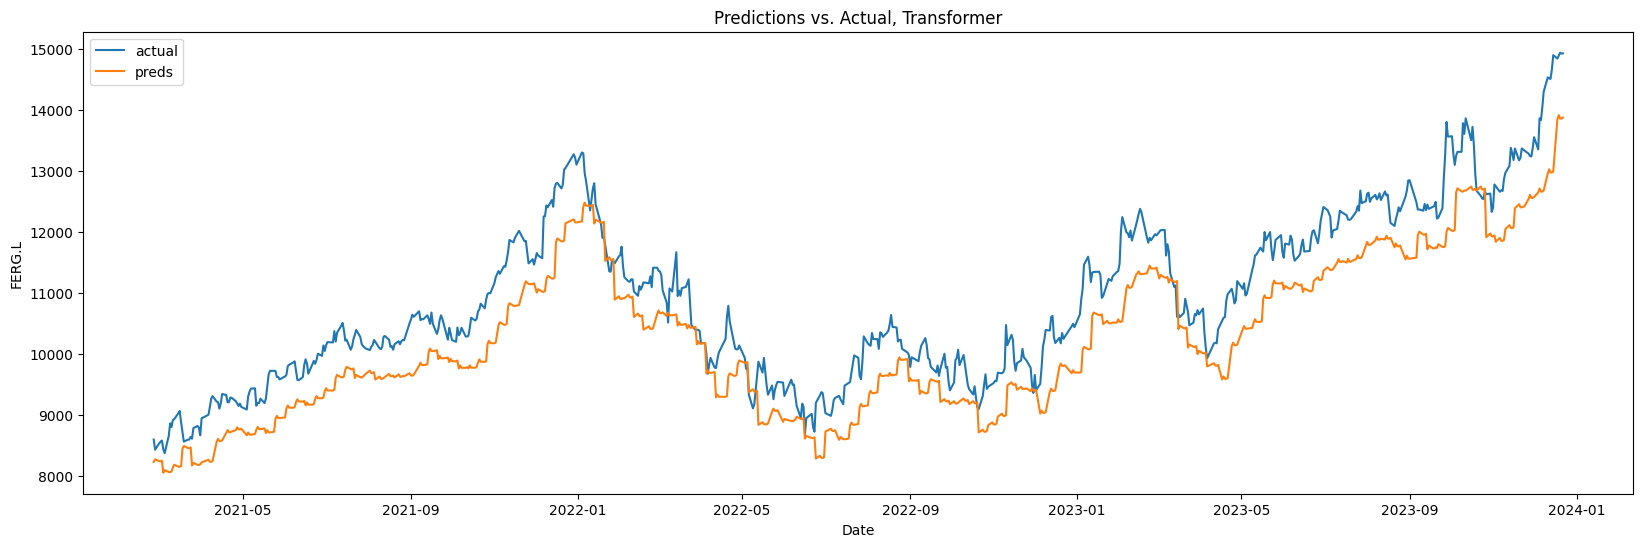

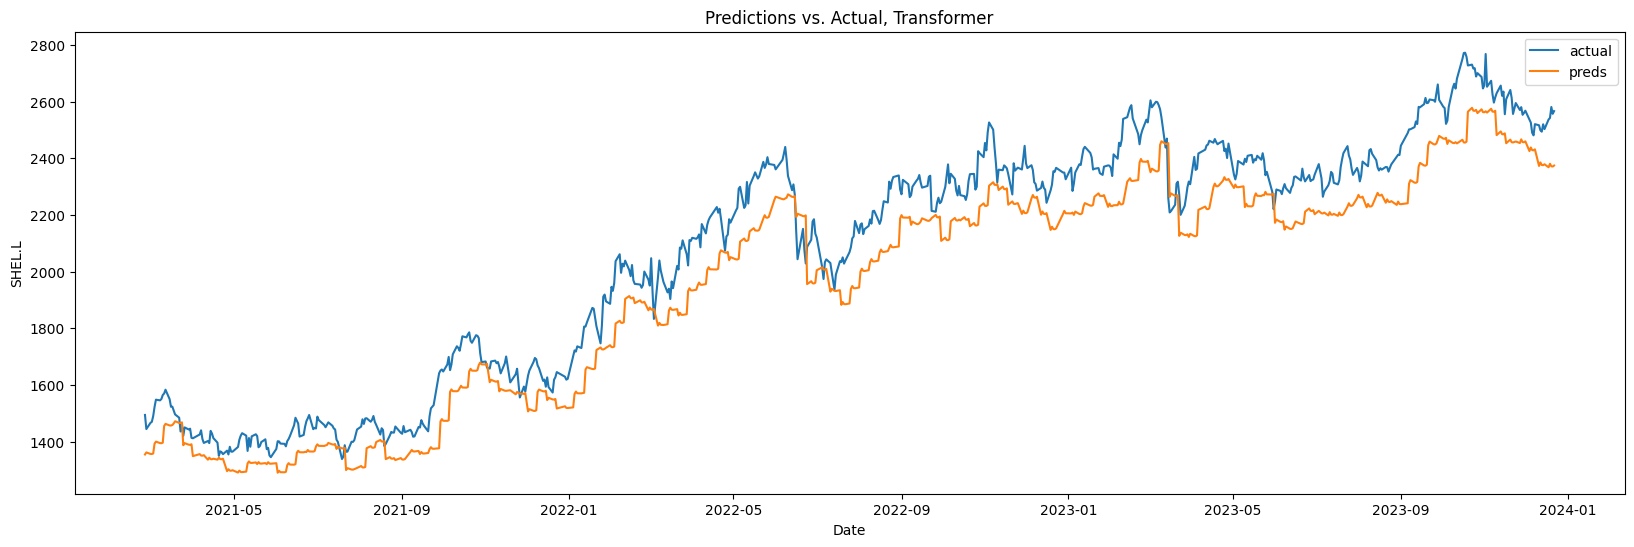

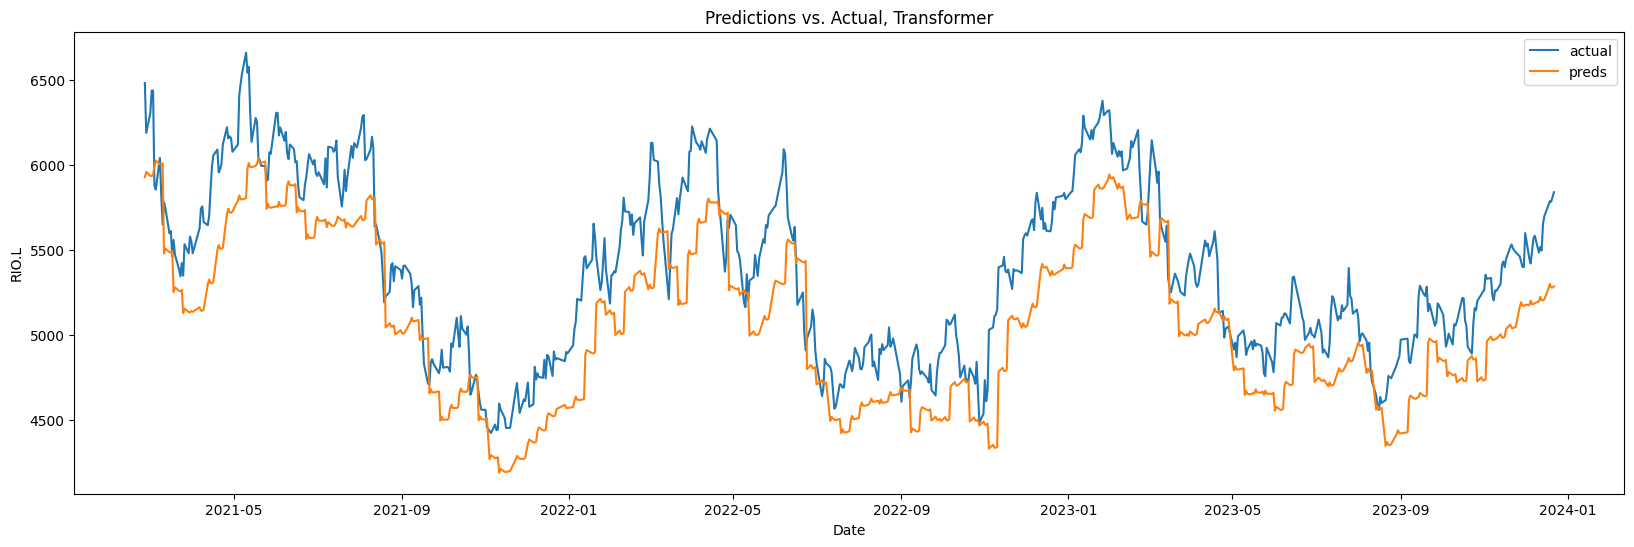

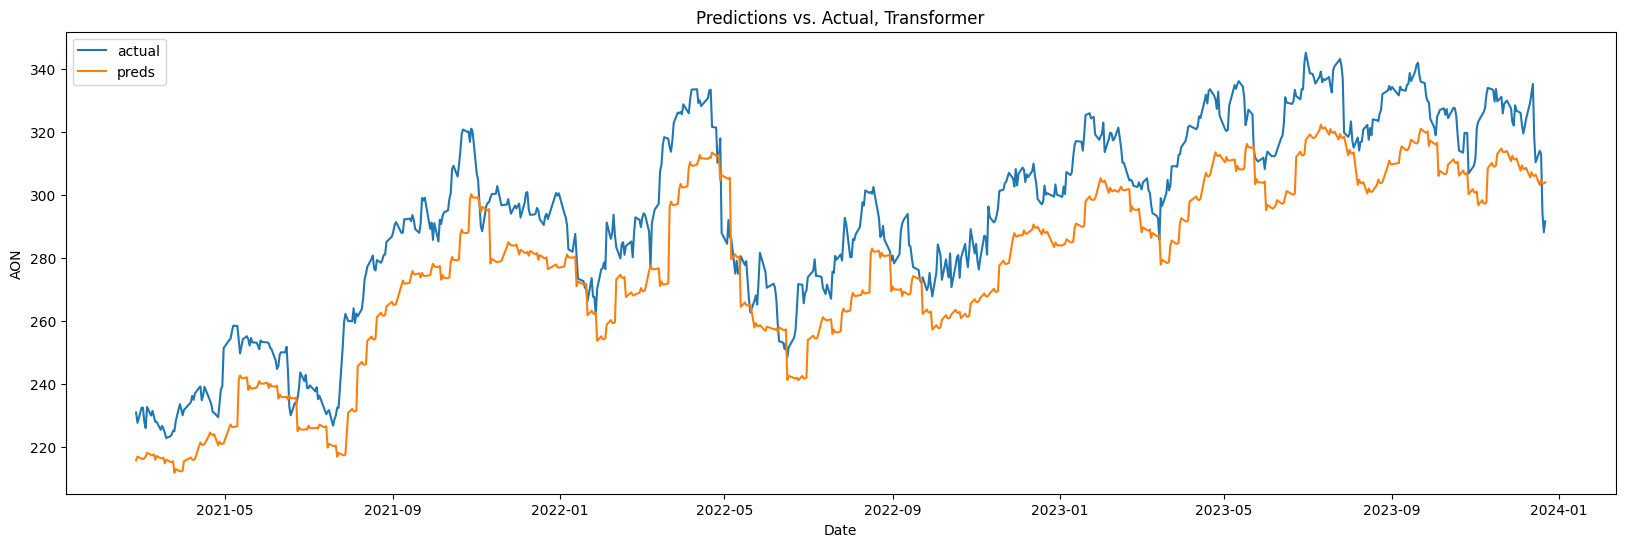

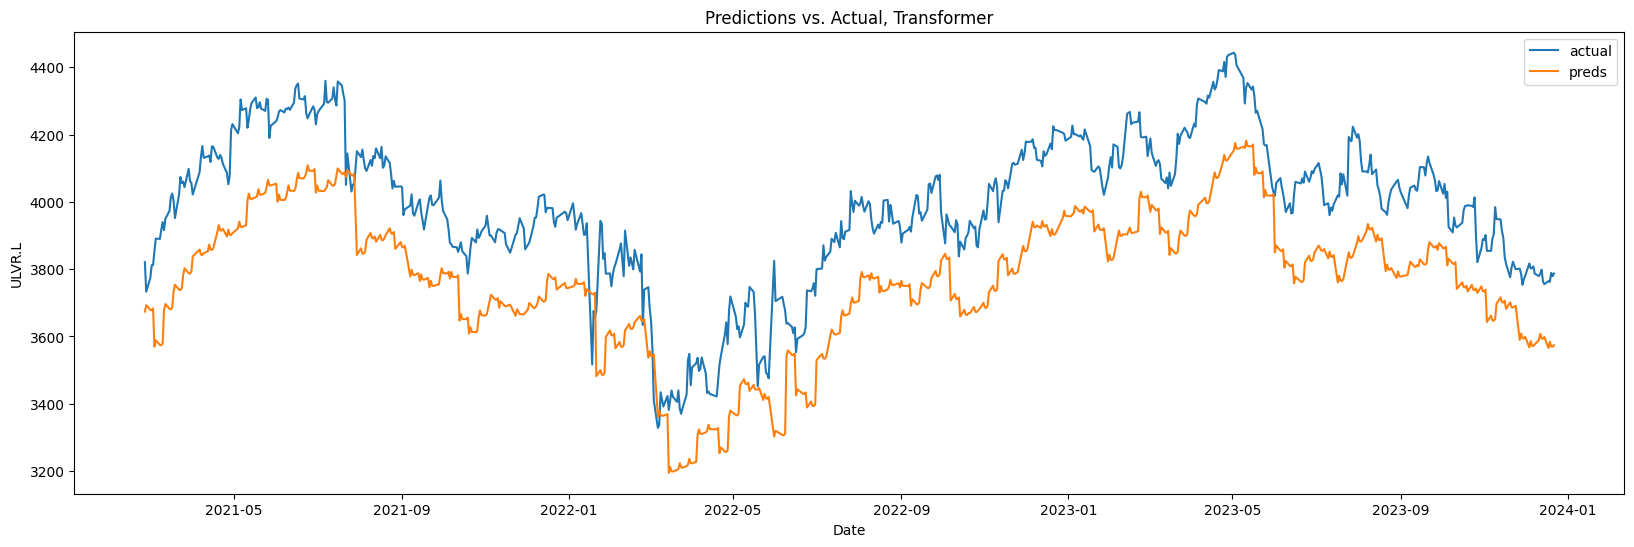

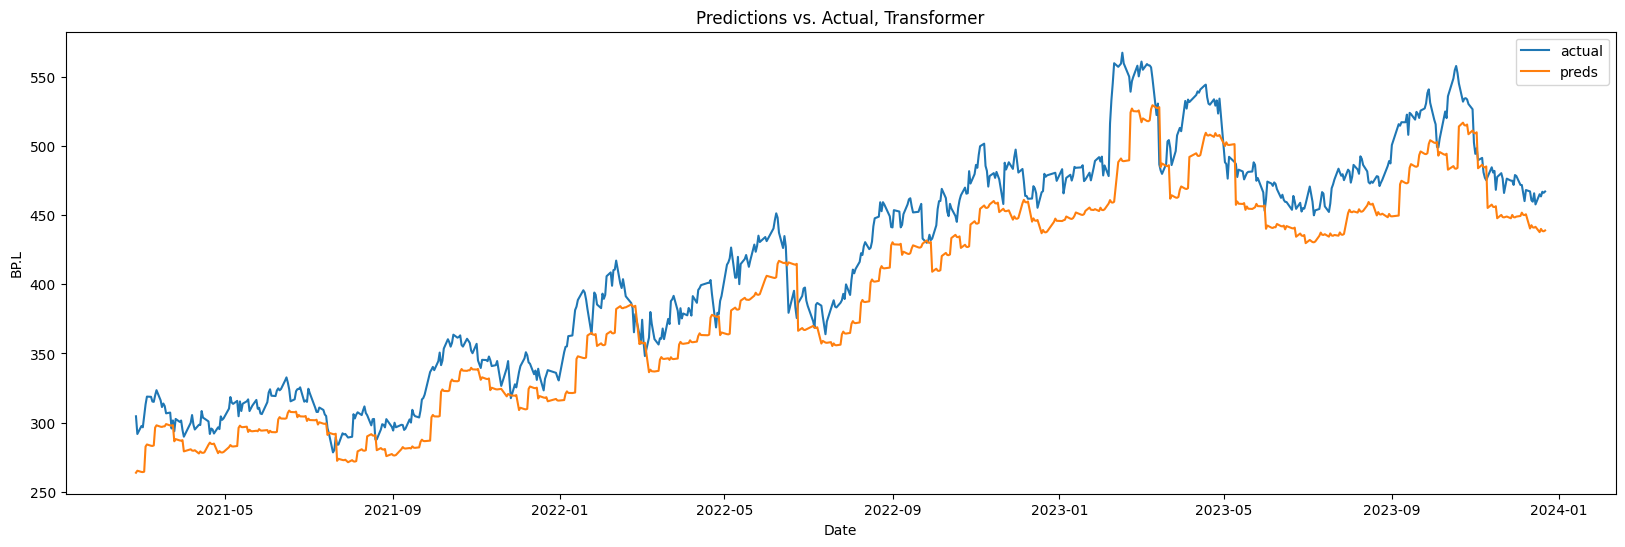

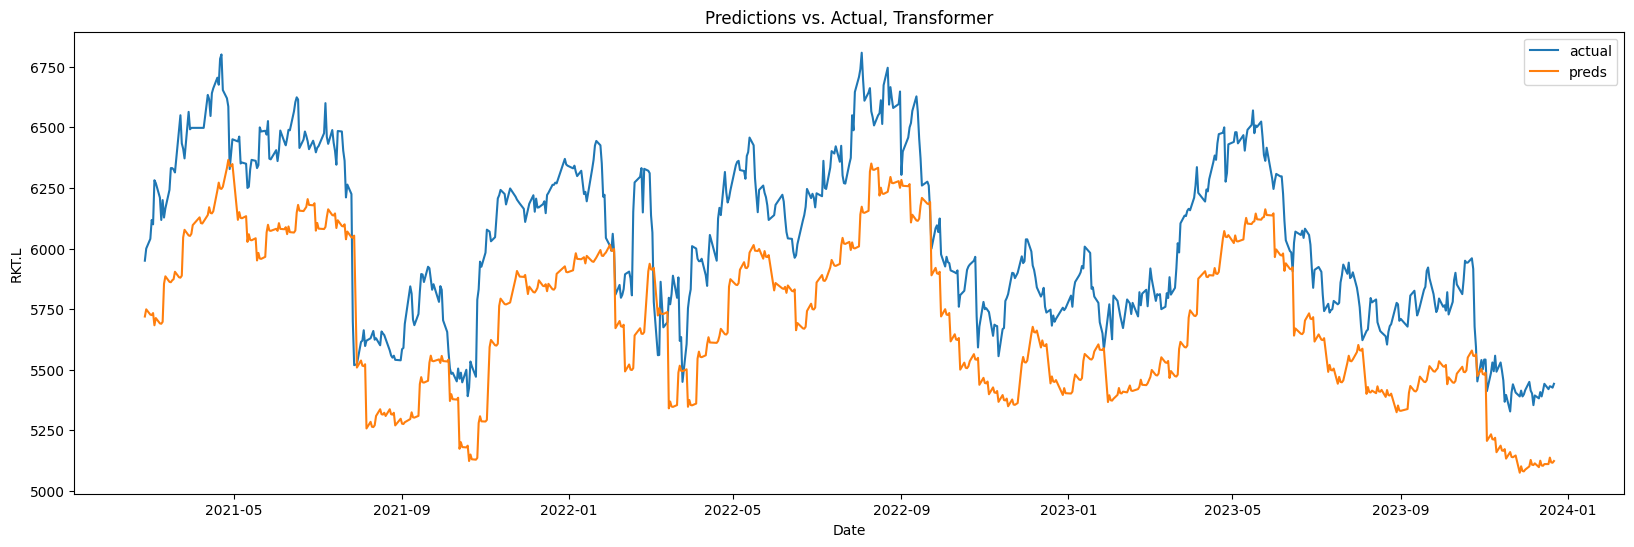

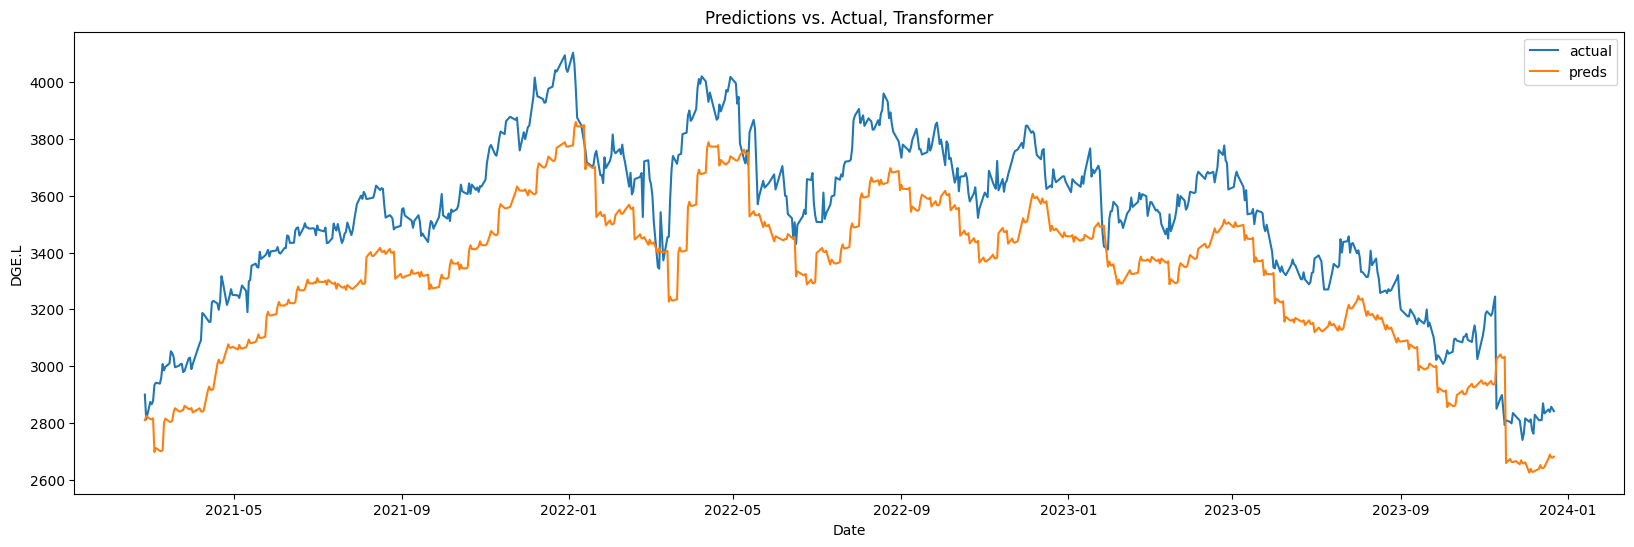

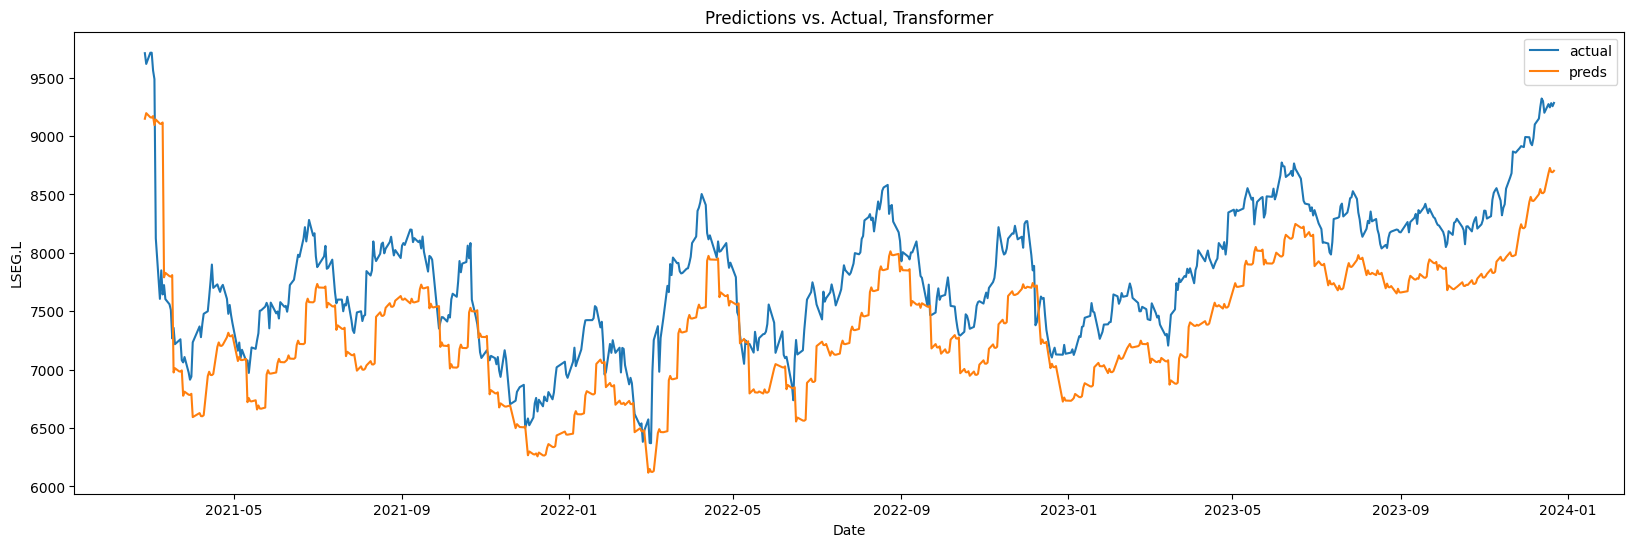

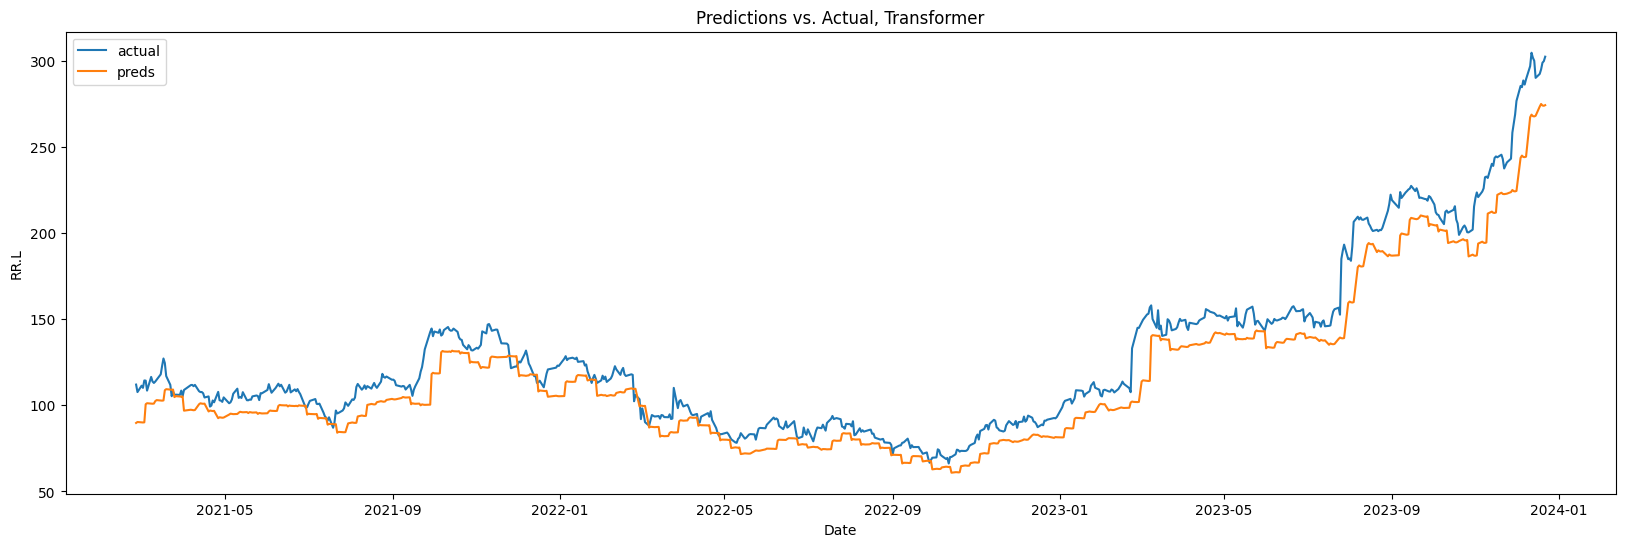

In [21]:
for i in range(len(data.ticker)):
    plot_results(test[i], predict[i].predictions, data.df[data.df.columns[i]], title_suffix='Transformer', xlabel = data.df.columns[i], image_name= data.ticker[i])